In [1]:
import numpy as np
import gpstk
from GNSS_TK import *
import matplotlib.pyplot as plt
%matplotlib inline

##Iono gradient WOOS/GARF PRN 26 20.7-21.3 hours 11/20/2003

In [2]:
st1=["data/woos324.03.n","data/woos324.03.o"]
st2=["data/garf324.03.n","data/garf3240.03o"]
t1,t2,Icode1,Iphase1,Icode2,Iphase2,VTECphase1,VTECphase2,ELEV1,ELEV2,IPP1,IPP2=getdata_stationpair(st1,st2,"GPS 26")

In [3]:
print len(IPP1),len(t1),len(Icode1),len(Iphase1),len(VTECphase1),len(ELEV1)
print len(IPP2),len(t2),len(Icode2),len(Iphase2),len(VTECphase2),len(ELEV2)
print min(t1),max(t1)
print min(t2),max(t2)

757 757 757 757 757 757
761 761 761 761 761 761
14459.0 77519.0
14580.0 77550.0


In [4]:
tiempos1=get_obstimes(t1,74520,76680)
tiempos2=get_obstimes(t2,74520,76680)
#Nos quedamos con los datos entre las 20.7 y 21.3 horas
print tiempos1[:10]
print tiempos2[:10]
print len(tiempos1),len(tiempos2)
tiempos1+=1
tiempos2=np.delete(tiempos2,0)
print len(tiempos1),len(tiempos2)
print tiempos1[:10]
print tiempos2[:10]
#Crear una funcion que:
# 1 encuentre el punto en comun a partir del cual comienza y quite las diferencias -->debe ser multiplo de 30 
# y cambiar en los diccionarios las claves :/


[ 74549.  74579.  74609.  74639.  74669.  74699.  74729.  74759.  74789.
  74819.]
[ 74520.  74550.  74580.  74610.  74640.  74670.  74700.  74730.  74760.
  74790.]
72 73
72 72
[ 74550.  74580.  74610.  74640.  74670.  74700.  74730.  74760.  74790.
  74820.]
[ 74550.  74580.  74610.  74640.  74670.  74700.  74730.  74760.  74790.
  74820.]


In [5]:
tcommon=np.intersect1d(tiempos1,tiempos2)
print "Observations: ",np.size(tcommon)

Observations:  72


###First Results: Delay and Slant ZOB GARF

In [6]:
D=[]
gg=[]#gradient
#t1,t2,Icode1,Iphase1,Icode2,Iphase2,VTECphase1,VTECphase2,ELEV1,ELEV2,IPP1,IPP2
IC1,IC2,IPh1,IPh2,IPPs1,IPPs2=[],[],[],[],[],[]
t,EL1,EL2=[],[],[]
print  IPP1[tcommon[0]-1][0] #desfase de 1 segundo -1

-235015.098013


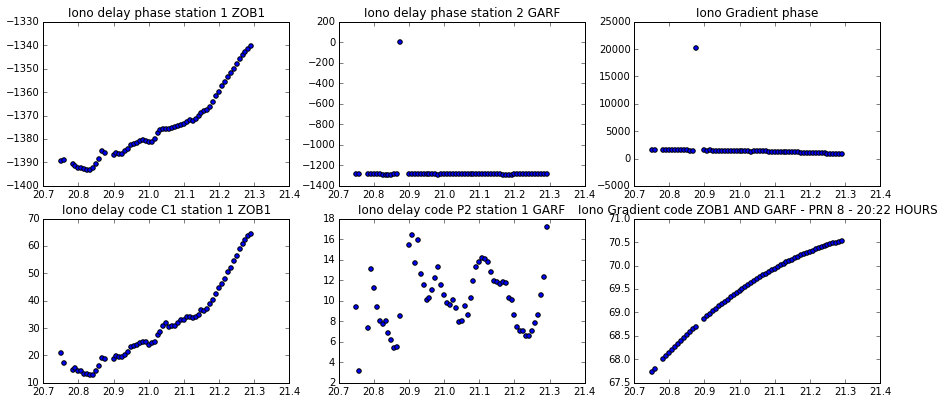

In [7]:
for time in tcommon:
    d=np.sqrt((IPP1[time-1][0]-IPP2[time][0])**2+(IPP1[time-1][1]-IPP2[time][1])**2+(IPP1[time-1][2]-IPP2[time][2])**2)
    if Iphase1[time-1]>-200000 and Iphase1[time-1]<0 and Iphase2[time]>-2000 and Iphase2[time]<100000 : #ese errorcito se soluciona bajando el umbral en getdata
        D.append(d)
        EL1.append(ELEV1[time-1])
        EL2.append(ELEV2[time])
        IC1.append(Icode1[time-1])
        IC2.append(Icode2[time])
        IPh1.append(Iphase1[time-1])
        IPh2.append(Iphase2[time])
        t.append(time)

D=np.array(D)/1000
t=np.array(t)/3600 
IC1=np.array(IC1)
IC2=np.array(IC2)
IP1=np.array(IPh1)
IP2=np.array(IPh2)
EL1=np.array(EL1)
EL2=np.array(EL2)

plt.figure(figsize=(15,10))
plt.subplot(3,3,1)
plt.title("Iono delay phase station 1 ZOB1")
plt.scatter(t,IP1)
plt.subplot(3,3,2)
plt.title("Iono delay phase station 2 GARF")
plt.scatter(t,IP2)
plt.subplot(3,3,3)
plt.title("Iono Gradient phase")
DelayP=((IP2-IP1)*1000)/D #Km/mm
plt.scatter(t,DelayP)
plt.subplot(3,3,4)
plt.title("Iono delay code C1 station 1 ZOB1")
plt.scatter(t,IC1)
plt.subplot(3,3,5)
plt.title("Iono delay code P2 station 1 GARF")
plt.scatter(t,IC2)
plt.subplot(3,3,6)
plt.title("Iono Gradient code ZOB1 AND GARF - PRN 8 - 20:22 HOURS")
DelayC=((IC1-IC2)*1000)/D
plt.scatter(t,D)

#IOD Cycle Slips


In [8]:
jumps1=datajump(IP1,t,2.5) #tgap1
print "Data jumps in slant delay station1 : ",jumps1

jumps2=datajump(IP2,t,2.5) #tgap1
print "Data jumps in  in slant delay station2: ",jumps2

Data jumps in slant delay station1 :  [12 29]
Data jumps in  in slant delay station2:  [13]


In [9]:
print t[jumps1]
print t[jumps2]

[ 20.86666667  21.025     ]
[ 20.875]


In [10]:
print IP1[11],IP1[12],IP1[13] #3 meters of diff
print IP1[28],IP1[29],IP1[30] #7

print IP2[12],IP2[13],IP2[14] #WTF!

-1388.71832998 -1385.25362028 -1385.97899035
-1380.15281722 -1377.24615346 -1376.09778205
-1288.25584596 0.0 -1284.93846938


##Continuous arcs are divided into "several" subarcs
Using de datajumps we split our arc into miniarcs

In [11]:
miniarcs1=sub_arcs(IP1,jumps1)
print "Total subarcs=",len(miniarcs1)
for i in range(len(miniarcs1)):
    print "Arc ",i," has ",len(miniarcs1[i])," elements"

Total subarcs= 3
Arc  0  has  12  elements
Arc  1  has  17  elements
Arc  2  has  33  elements


In [12]:
miniarcs2=sub_arcs(IP2,jumps2)
print "Total subarcs=",len(miniarcs2)
for i in range(len(miniarcs2)):
    print "Arc ",i," has ",len(miniarcs2[i])," elements" 

Total subarcs= 2
Arc  0  has  13  elements
Arc  1  has  49  elements


##Short arc Removal
Also, miniarcs with less than 10 elements, or five minutes are removed. **The short arcs need to be discarded because leveling errors for those arcs are typically large and cause ionospheric delay estimation errors. **

In [13]:
print len(IP1),len(IC1),len(IP2),len(IC2),len(t),len(D)
miniarcs1,miniarcs2,IP1,IP2,IC1,IC2,t,D=remove_short(miniarcs1,miniarcs2,IP1,IP2,IC1,IC2,t,D)
print len(IP1),len(IC1),len(IP2),len(IC2),len(t),len(D)

62 62 62 62 62 62
Arc #  0
Arc #  1
Arc #  2
62 62 62 62 62 62


In [14]:
print miniarcs1

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]), array([29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
       46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61])]


In [15]:
print miniarcs2

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
       30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
       47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61])]


##Polinomial fit & Outlier detection and Removal
###Polinomial fit

Station 1 subarcs
Biggest Slip detected with polinomyal fit:  1 20.7583333333
Biggest Slip detected with polinomyal fit:  16 21.0166666667
Biggest Slip detected with polinomyal fit:  1 21.1583333333


/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


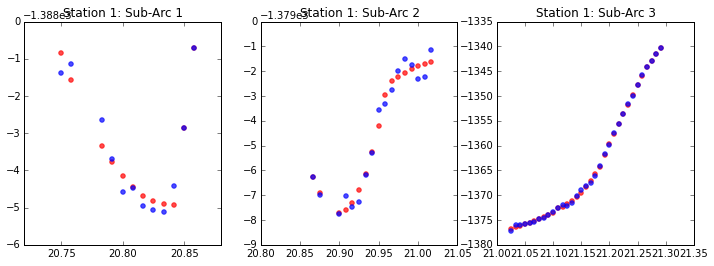

In [16]:
print "Station 1 subarcs"
plt.figure(figsize=(12,4))
P11,pslip11=poly_fit(IP1[miniarcs1[0]],t[miniarcs1[0]])
plt.subplot(1,3,1)
plt.title("Station 1: Sub-Arc 1")
plt.scatter(t[miniarcs1[0]],P11,color="red",alpha=.7)
plt.scatter(t[miniarcs1[0]],IP1[miniarcs1[0]],color="blue",alpha=.7)
print "Biggest Slip detected with polinomyal fit: ",pslip11,t[miniarcs1[0]][pslip11] #compare with station 2 slip,index[if all three arcs where united],time

P12,pslip12=poly_fit(IP1[miniarcs1[1]],t[miniarcs1[1]])
plt.subplot(1,3,2)
plt.title("Station 1: Sub-Arc 2")
plt.scatter(t[miniarcs1[1]],P12,color="red",alpha=.7)
plt.scatter(t[miniarcs1[1]],IP1[miniarcs1[1]],color="blue",alpha=.7)
print "Biggest Slip detected with polinomyal fit: ",pslip12,t[miniarcs1[1]][pslip12]

P13,pslip13=poly_fit(IP1[miniarcs1[2]],t[miniarcs1[2]])
plt.subplot(1,3,3)
plt.title("Station 1: Sub-Arc 3")
plt.scatter(t[miniarcs1[2]],P13,color="red",alpha=.7)
plt.scatter(t[miniarcs1[2]],IP1[miniarcs1[2]],color="blue",alpha=.7)
print "Biggest Slip detected with polinomyal fit: ",pslip13,t[miniarcs1[2]][pslip12]

Station 2 subarcs
Biggest Slip detected with polinomyal fit:  1 20.7583333333
Biggest Slip detected with polinomyal fit:  0 20.875


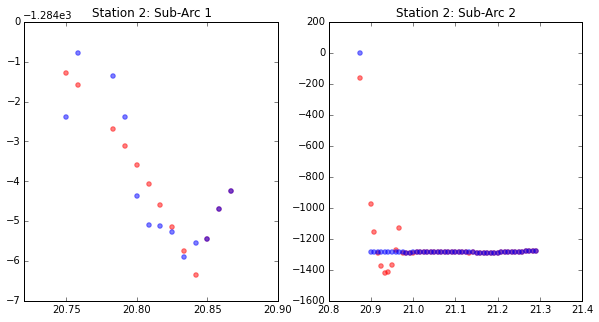

In [17]:
print "Station 2 subarcs"
plt.figure(figsize=(10,5))
P21,pslip21=poly_fit(IP2[miniarcs2[0]],t[miniarcs2[0]])
plt.subplot(1,2,1)
plt.title("Station 2: Sub-Arc 1")
plt.scatter(t[miniarcs2[0]],P21,color="red",alpha=.5)
plt.scatter(t[miniarcs2[0]],IP2[miniarcs2[0]],color="blue",alpha=.5)
print "Biggest Slip detected with polinomyal fit: ",pslip21,t[miniarcs2[0]][pslip21]

P22,pslip22=poly_fit(IP2[miniarcs2[1]],t[miniarcs2[1]])
plt.subplot(1,2,2)
plt.title("Station 2: Sub-Arc 2")
plt.scatter(t[miniarcs2[1]],P22,color="red",alpha=.5)
plt.scatter(t[miniarcs2[1]],IP2[miniarcs2[1]],color="blue",alpha=.5)
print "Biggest Slip detected with polinomyal fit: ",pslip22,t[miniarcs2[1]][pslip22]

###Outlier Factor 

In [18]:
outliers11,oslip11=outlier_detect(IP1[miniarcs1[0]],t[miniarcs1[0]]*3600) #mandarle el jump acá ? O.o
print "Elements in OFt: ",outliers11.size
print "Biggest slip detected in: ",oslip11
print IP1[miniarcs1[0]][oslip11]
print t[miniarcs1[0]][oslip11]

Elements in OFt:  12
Biggest slip detected in:  2
-1390.63416907
20.7833333333


In [19]:
outliers12,oslip12=outlier_detect(IP1[miniarcs1[1]],t[miniarcs1[1]]*3600)
print "Elements in OFt: ",outliers12.size
print "Biggest slip detected in: ",oslip12
print IP1[miniarcs1[1]][oslip12]
print t[miniarcs1[1]][oslip12]

Elements in OFt:  17
Biggest slip detected in:  8
-1382.54630185
20.95


In [20]:
outliers13,oslip13=outlier_detect(IP1[miniarcs1[2]],t[miniarcs1[2]]*3600)
print "Elements in OFt: ",outliers13.size
print "Biggest slip detected in: ",oslip13
print IP1[miniarcs1[2]][oslip13]
print t[miniarcs1[2]][oslip13]

Elements in OFt:  33
Biggest slip detected in:  27
-1347.8691948
21.25


In [21]:
outliers21,oslip21=outlier_detect(IP2[miniarcs2[0]],t[miniarcs2[0]]*3600)
print "Elements in OFt: ",outliers21.size
print "Biggest slip detected in: ",oslip21
print IP2[miniarcs2[0]][oslip21]
print t[miniarcs2[0]][oslip21]

Elements in OFt:  13
Biggest slip detected in:  2
-1285.34776924
20.7833333333


In [22]:
outliers22,oslip22=outlier_detect(IP2[miniarcs2[1]],t[miniarcs2[1]]*3600)
print "Elements in OFt: ",outliers22.size
print "Biggest slip detected in: ",oslip22
print IP2[miniarcs2[1]][oslip22]
print t[miniarcs2[1]][oslip22]



Elements in OFt:  49
Biggest slip detected in:  0
0.0
20.875


In [23]:
def fixslip(t,L,threshold=0.8):
    Poly,pslip=poly_fit(L,t) #residuals bigger than threshold 0.8, and biggest slip detected
    confirmed=[]#confirmed outliers
    while len(Poly)!=0: #if there are outliers
        __,oslip=outlier_detect(L,t*3600) #biggest slip detected with outlier factor
        if pslip==oslip and pslip not in confirmed and pslip!=None:
            confirmed.append(pslip) #recorded as an outlier
            L=np.delete(L,pslip) #remove outlier
            t=np.delete(t,pslip)
            print "Poly: ",pslip,"Outlier factor: ",oslip
        Poly,npslip=poly_fit(L,t)  
        if npslip==pslip:
            break
        else:
            pslip=npslip
    return L,t,confirmed

In [24]:
Lnew11,tnew11,outliers11=fixslip(t[miniarcs1[0]],IP1[miniarcs1[0]],threshold=0.8)
print outliers11,len(t[miniarcs1[0]]),len(Lnew11)
Lnew12,tnew12,outliers12=fixslip(t[miniarcs1[1]],IP1[miniarcs1[1]],threshold=0.8)
print outliers12,len(t[miniarcs1[1]]),len(Lnew12)
Lnew13,tnew13,outliers13=fixslip(t[miniarcs1[2]],IP1[miniarcs1[2]],threshold=0.8)#same O.o is this good or bad?
print outliers13,len(t[miniarcs1[2]]),len(Lnew13)

[] 12 12
[] 17 17
[] 33 33


/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


In [25]:
Lnew21,tnew21,outliers21=fixslip(t[miniarcs2[0]],IP2[miniarcs2[0]],threshold=0.8)
print outliers21,len(IP2[miniarcs2[0]]),len(Lnew21)
Lnew22,tnew22,outliers22=fixslip(t[miniarcs2[1]],IP2[miniarcs2[1]],threshold=0.8)  #aquí DEBE REMOVER !!!!! OJO
print outliers22,len(IP2[miniarcs2[1]]),len(Lnew22)

[] 13 13
Poly:  0 Outlier factor:  0
[0] 49 48


In [26]:
miniarcs2[1],miniarcs1=remove_fix(miniarcs2[1],miniarcs1,oslip22)

Delete index:  13
[12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28]
[12 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28]


In [27]:
print miniarcs1

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]), array([29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
       46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61])]


In [28]:
print miniarcs2

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
       31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
       48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61])]


In [29]:
#Station 1 jumps1 [12 29]
#0-11
print len(t[miniarcs1[0]])
Lfactor11,new_IPHASE_arc11=levelphase(IC1[miniarcs1[0]],IP1[miniarcs1[0]],EL1[[[miniarcs1[0]]]]) #IC1 code delay on station1
print "Leveling factor: ",Lfactor11,new_IPHASE_arc11.size

12
Leveling factor:  1406.37539122 12


In [30]:
print len(t[miniarcs1[1]])
Lfactor12,new_IPHASE_arc12=levelphase(IC1[miniarcs1[1]],IP1[miniarcs1[1]],EL1[miniarcs1[1]]) #IC1 code delay on station1
print "Leveling factor: ",Lfactor12,new_IPHASE_arc12.size

16
Leveling factor:  1405.52083076 16


In [31]:
print len(t[miniarcs1[2]])
Lfactor13,new_IPHASE_arc13=levelphase(IC1[miniarcs1[2]],IP1[miniarcs1[2]],EL1[miniarcs1[2]]) #IC1 code delay on station1
print "Leveling factor: ",Lfactor13,new_IPHASE_arc13.size

33
Leveling factor:  1405.20178871 33


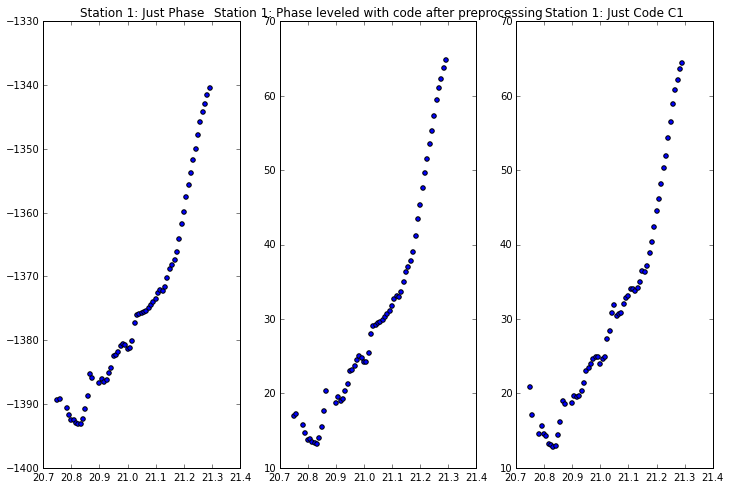

In [32]:
plt.figure(figsize=(12,8))

plt.subplot(1,3,1)
plt.title("Station 1: Just Phase")
plt.scatter(t,IP1)

plt.subplot(1,3,2)
plt.title("Station 1: Phase leveled with code after preprocessing")
plt.scatter(t[miniarcs1[0]],new_IPHASE_arc11)
plt.scatter(t[miniarcs1[1]],new_IPHASE_arc12)
plt.scatter(t[miniarcs1[2]],new_IPHASE_arc13)

plt.subplot(1,3,3)
plt.title("Station 1: Just Code C1")
plt.scatter(t,IC1)

In [33]:
print len(t[miniarcs2[0]])
Lfactor21,new_IPHASE_arc21=levelphase(IC2[miniarcs2[0]],IP2[miniarcs2[0]],EL2[miniarcs2[0]]) #IC2 code delay on station2
print "Leveling factor: ",Lfactor21,new_IPHASE_arc21.size

13
Leveling factor:  1295.83680304 13


In [34]:
print len(t[miniarcs2[1]])
Lfactor22,new_IPHASE_arc22=levelphase(IC2[miniarcs2[1]],IP2[miniarcs2[1]],EL2[miniarcs2[1]]) #IC2 code delay on station2
print "Leveling factor: ",Lfactor22,new_IPHASE_arc22.size

48
Leveling factor:  1297.43049511 48


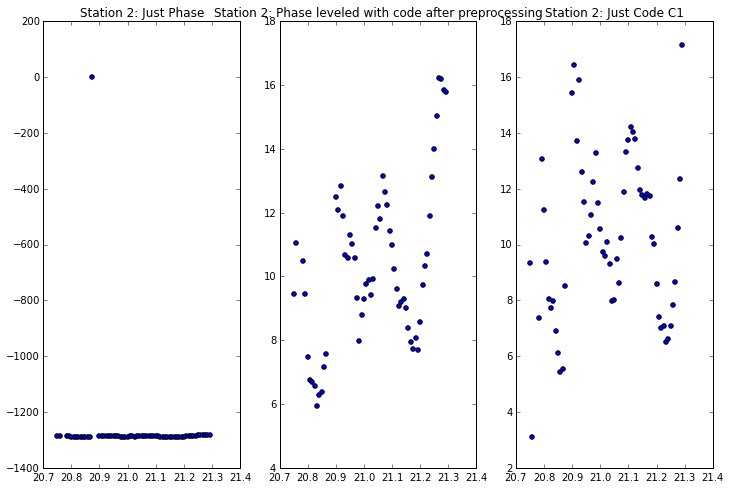

In [35]:
plt.figure(figsize=(12,8))

plt.subplot(1,3,1)
plt.title("Station 2: Just Phase")
plt.scatter(t,IP2)

plt.subplot(1,3,2)
#plt.ylim(-2,20)
plt.title("Station 2: Phase leveled with code after preprocessing")
plt.scatter(t[miniarcs2[0]],new_IPHASE_arc21)
plt.scatter(t[miniarcs2[1]],new_IPHASE_arc22)

plt.subplot(1,3,3)
plt.title("Station 2: Just Code C1")
plt.scatter(t,IC2)

In [36]:
ntimes1=np.hstack((t[miniarcs1[0]],t[miniarcs1[1]],t[miniarcs1[2]])) 
new_IPHASE_arc1=np.hstack((new_IPHASE_arc11,new_IPHASE_arc12,new_IPHASE_arc13 )) 

ntimes2=np.hstack((t[miniarcs2[0]],t[miniarcs2[1]])) 
new_IPHASE_arc2=np.hstack((new_IPHASE_arc21,new_IPHASE_arc22 )) 

In [37]:
print ntimes1.size,new_IPHASE_arc1.size
print ntimes2.size,new_IPHASE_arc2.size

61 61
61 61


In [38]:
D=np.delete(D,13)

61 61


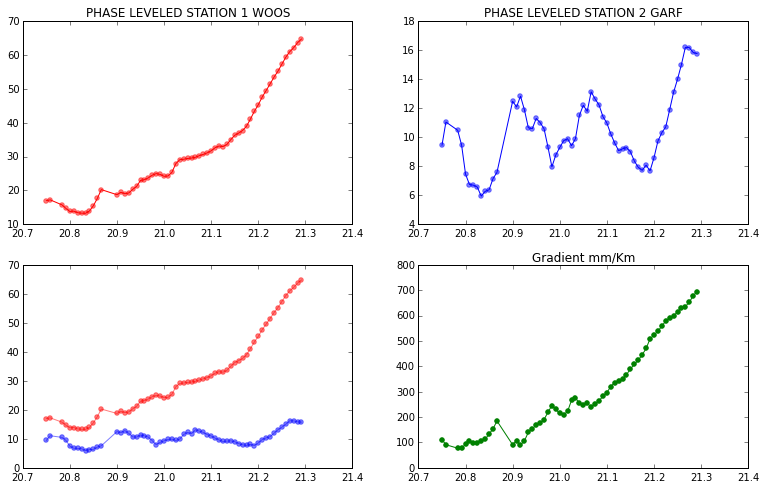

In [39]:
plt.figure(figsize=(13,8))
plt.subplot(2,2,1)
plt.title("PHASE LEVELED STATION 1 WOOS")
plt.scatter(ntimes1,new_IPHASE_arc1,color="red",alpha=.5)
plt.plot(ntimes1,new_IPHASE_arc1,color="red")
plt.subplot(2,2,2)
plt.title("PHASE LEVELED STATION 2 GARF")
plt.scatter(ntimes2,new_IPHASE_arc2,color="blue",alpha=.5)
plt.plot(ntimes2,new_IPHASE_arc2,color="blue")
plt.subplot(2,2,3)
plt.scatter(ntimes1,new_IPHASE_arc1,color="red",alpha=.5)
plt.plot(ntimes1,new_IPHASE_arc1,color="red",alpha=.5)
plt.scatter(ntimes2,new_IPHASE_arc2,color="blue",alpha=.5)
plt.plot(ntimes2,new_IPHASE_arc2,color="blue",alpha=.5)
##aELIMINAR TAMBIEN EL SHORT ARC EN LA OTRA ESTACION Y EN LA DISTANCIA ENTRE IPPS
print len(new_IPHASE_arc1),len(new_IPHASE_arc2)

gradient=(new_IPHASE_arc1-new_IPHASE_arc2)*1000 
plt.subplot(2,2,4)
plt.title("Gradient mm/Km")
plt.scatter(ntimes1,gradient/D,color="green")
plt.plot(ntimes1,gradient/D,color="green")
